Kontras (Contrast):
- Nilai Tinggi: Citra dengan banyak perbedaan intensitas yang tajam, seperti citra dengan tepi yang jelas atau pola dengan perubahan warna yang kontras (misalnya, gambar zebra atau teks dengan latar belakang putih).
- Nilai Rendah: Citra dengan perubahan intensitas yang halus atau sedikit variasi warna (misalnya, gambar langit biru cerah atau dinding dengan warna solid).

Dissimilarity:
- Nilai Tinggi: Citra dengan banyak variasi dalam intensitas piksel yang berdekatan, mirip dengan kontras tinggi (misalnya, gambar dengan banyak pola acak atau tepi tajam).
- Nilai Rendah: Citra yang lebih homogen dengan perubahan intensitas yang kecil (misalnya, permukaan yang halus dan seragam).

Homogenitas (Homogeneity):
- Nilai Tinggi: Citra yang sangat seragam dengan sedikit variasi dalam intensitas (misalnya, tekstur halus seperti kain katun polos atau area besar dengan warna solid).
- Nilai Rendah: Citra dengan banyak variasi dalam intensitas piksel (misalnya, gambar dengan banyak tekstur kompleks seperti daun pohon atau kulit kayu).

Entropi (Entropy):
- Nilai Tinggi: Citra yang sangat acak atau kompleks dengan distribusi intensitas yang tidak teratur (misalnya, citra dengan banyak noise atau pola acak).
- Nilai Rendah: Citra yang lebih teratur dan terstruktur (misalnya, area dengan warna solid atau pola berulang yang konsisten).

Energi (Energy):
- Nilai Tinggi: Citra dengan pola yang sangat teratur dan berulang, menunjukkan konsistensi yang tinggi dalam distribusi intensitas (misalnya, pola geometris yang berulang atau tekstur kain berulang).
- Nilai Rendah: Citra yang lebih acak dan kurang terstruktur (misalnya, gambar dengan banyak noise atau tekstur acak).

ASM (Angular Second Moment):
- Nilai Tinggi: Sama dengan energi, nilai tinggi menunjukkan tekstur yang seragam dan konsisten (misalnya, pola berulang yang jelas).
- Nilai Rendah: Sama dengan energi, nilai rendah menunjukkan tekstur yang lebih acak (misalnya, gambar dengan banyak variasi intensitas atau noise).

Korelasi (Correlation):
- Nilai Tinggi: Citra di mana nilai intensitas piksel memiliki hubungan linier yang kuat (misalnya, gradien halus atau pola dengan transisi warna yang konsisten).
- Nilai Rendah: Citra dengan variasi intensitas yang lebih acak dan kurang teratur (misalnya, gambar dengan banyak noise atau variasi acak dalam intensitas).

In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import entropy
import seaborn as sns


# Data Loading

In [2]:
data = []
labels = []
paths = []
file_name = []
for sub_folder in os.listdir("rambu1cina\\"):
    sub_folder_files = os.listdir(os.path.join("rambu1cina\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("rambu1cina\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        data.append(img)
        labels.append(sub_folder)
        paths.append(img_path)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        if i == 50:
            break
        

# Data Augmentation

In [3]:
# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	data_augmented.append(data[i])
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])

	data_augmented.append(cv.rotate(data[i], cv.ROTATE_90_CLOCKWISE))
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])

	data_augmented.append(cv.rotate(data[i], cv.ROTATE_90_COUNTERCLOCKWISE))
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])

## Data Preparation

### Data Preprocessing

In [4]:
for i in range(len(data_augmented)):
    data_augmented[i] = cv.resize(data_augmented[i], (100, 100))
    data_augmented[i] = cv.equalizeHist(data_augmented[i])
    # sharpeing
    kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    data_augmented[i] = cv.filter2D(data_augmented[i], -1, kernel)


### Feature Extraction

In [5]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [6]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [7]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [8]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [9]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [10]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [11]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [12]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [13]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_augmented)):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [14]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [15]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [16]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [17]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [18]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [19]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [20]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [21]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [22]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasilEkstraksi.csv', index=False)

hasilEkstrak = pd.read_csv('hasilEkstraksi.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,010_0001.png,10,10884.912727,12647.963371,8267.320909,13444.097643,0.191795,0.164536,0.239329,0.152847,...,0.025705,0.013355,0.132874,0.120571,0.160328,0.115562,0.464192,0.377648,0.592723,0.338516
1,010_0002.png,10,8240.736061,13426.105091,10860.105152,12598.942965,0.241212,0.150396,0.190197,0.164332,...,0.017685,0.014819,0.162087,0.115246,0.132986,0.121734,0.593899,0.339104,0.465125,0.379781
2,010_0003.png,10,8240.736061,13426.105091,10860.105152,12598.942965,0.241212,0.150396,0.190197,0.164332,...,0.017685,0.014819,0.162087,0.115246,0.132986,0.121734,0.593899,0.339104,0.465125,0.379781
3,010_0004.png,10,15009.544545,18534.690950,14655.742525,19043.170697,0.228133,0.173941,0.241653,0.165256,...,0.033120,0.025377,0.175895,0.161429,0.181988,0.159301,0.351729,0.199819,0.368050,0.177852
4,010_0005.png,10,14623.396263,19000.434445,14988.062121,18465.633915,0.244074,0.166075,0.227355,0.175155,...,0.030481,0.025806,0.183279,0.159213,0.174589,0.160643,0.368715,0.178705,0.351869,0.201837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2032,30_00047.jpg,temp9,5347.722121,7065.964595,5846.968384,7085.694317,0.250980,0.183149,0.228348,0.175654,...,0.008569,0.006374,0.099979,0.080042,0.092571,0.079839,0.639654,0.526401,0.607319,0.525098
2033,30_00048.jpg,temp9,5347.722121,7065.964595,5846.968384,7085.694317,0.250980,0.183149,0.228348,0.175654,...,0.008569,0.006374,0.099979,0.080042,0.092571,0.079839,0.639654,0.526401,0.607319,0.525098
2034,30_00049.jpg,temp9,5815.349798,7003.781349,5312.689697,7040.167534,0.221903,0.172844,0.246752,0.176151,...,0.009778,0.006086,0.090983,0.078812,0.098882,0.078014,0.608268,0.529166,0.640867,0.526701
2035,30_00050.jpg,temp9,5347.722121,7065.964595,5846.968384,7085.694317,0.250980,0.183149,0.228348,0.175654,...,0.008569,0.006374,0.099979,0.080042,0.092571,0.079839,0.639654,0.526401,0.607319,0.525098


### Features Selection

<Axes: >

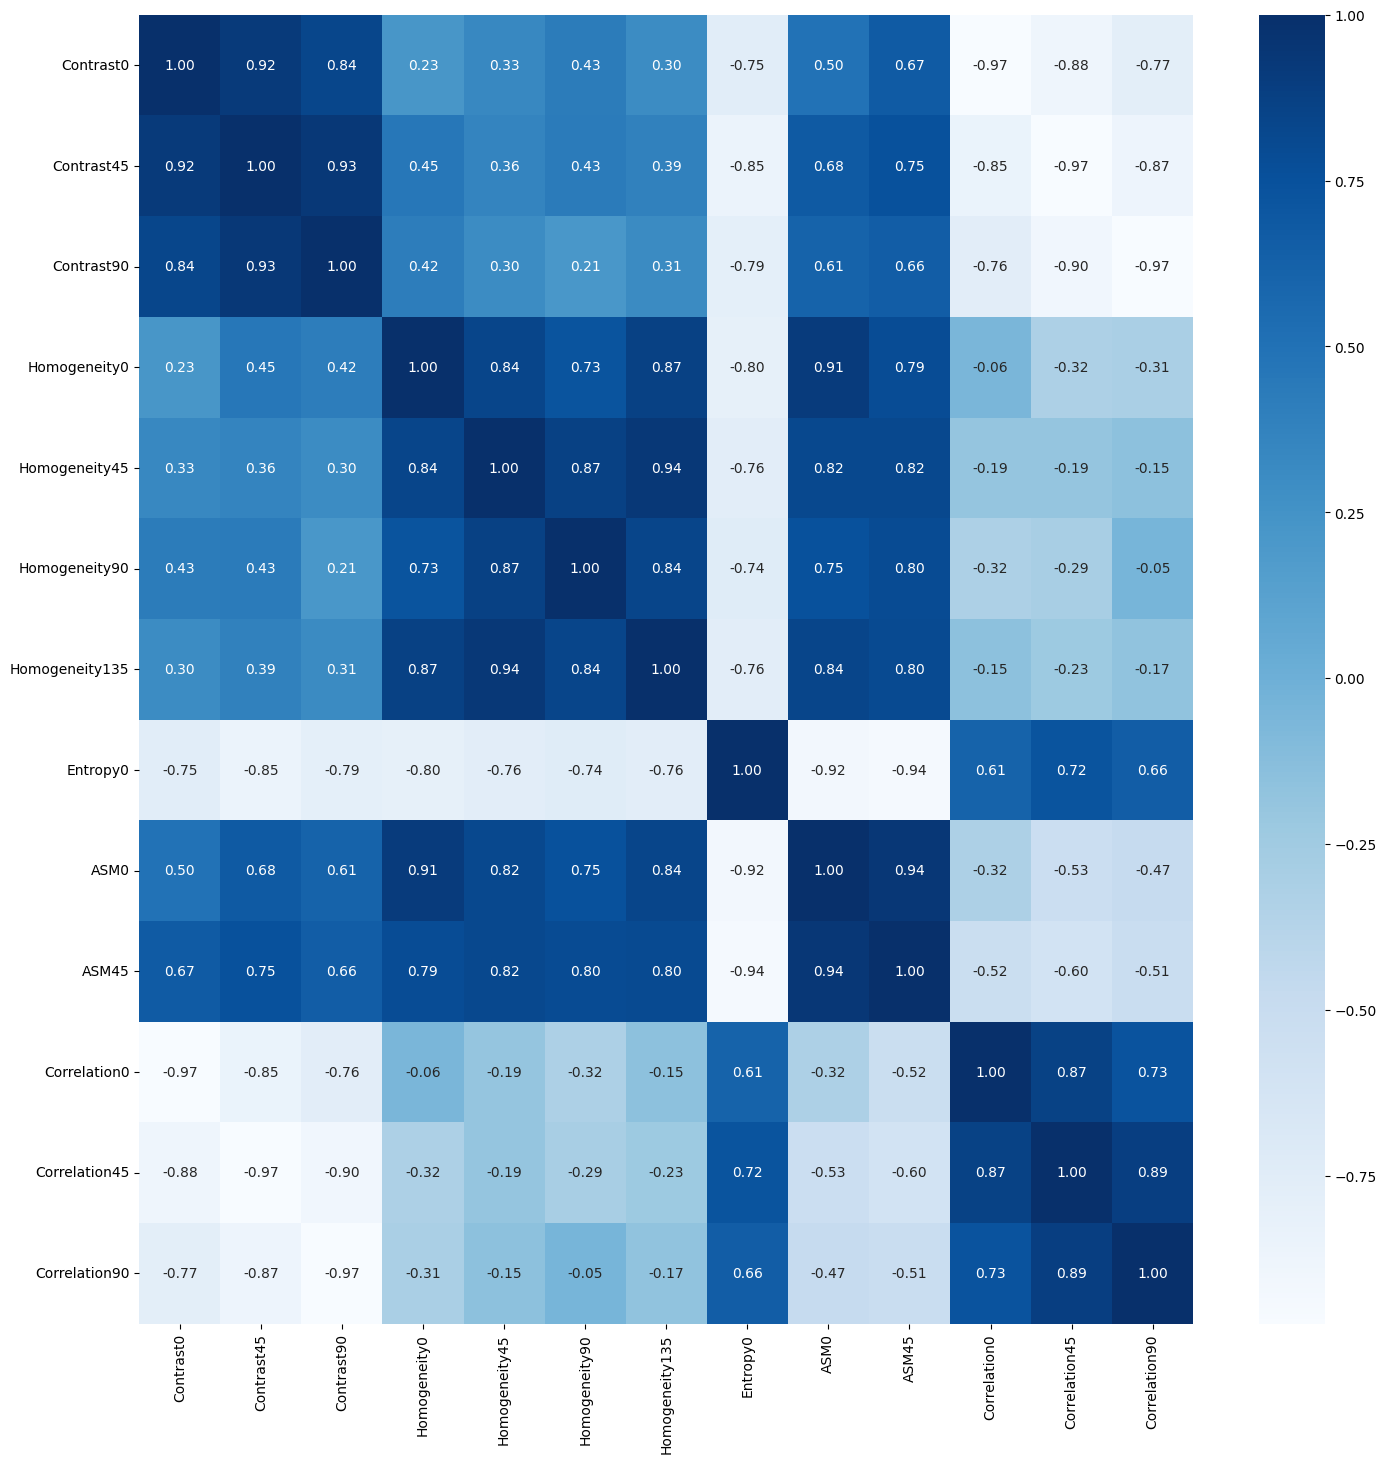

In [23]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### Splitting Data

In [24]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

         Contrast0    Contrast45    Contrast90  Homogeneity0  Homogeneity45  \
1244   6666.470101   9663.099378   7201.460404      0.289326       0.210322   
1546  10465.327879  15160.647587  11668.745556      0.248283       0.161178   
1121   9197.637273  14274.013366   9935.182929      0.275499       0.176908   
1163  17519.985859  20320.853382  17813.248990      0.281751       0.215157   
575    5868.655960  10539.422916   6260.583232      0.331644       0.233366   
...            ...           ...           ...           ...            ...   
1130   6640.125859  10927.343026   7499.723535      0.256757       0.178382   
1294  12719.132323  16667.444751  14082.087374      0.272555       0.201732   
860    5276.519596   9364.089073   6610.604444      0.251492       0.174567   
1459   6537.683737   9300.682277   5594.792121      0.216229       0.141108   
1126  11910.870606  16366.118151  11935.138081      0.263801       0.189941   

      Homogeneity90  Homogeneity135  Entropy0      

### Normalization

In [25]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

In [26]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1


print("KNN")
y_pred_knn, akurasiKNN, presisiKNN, recallKNN, f1KNN = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))

print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=50))

print("\nSVM")
y_pred_svm, akurasiSVM, presisiSVM, recallSVM, f1SVM = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))

KNN
Accuracy: 16.64%
Precision: 15.88%
Recall: 16.62%
F1 Score: 14.07%

Random Forest
Accuracy: 40.70%
Precision: 40.42%
Recall: 40.69%
F1 Score: 40.03%

SVM
Accuracy: 8.10%
Precision: 42.46%
Recall: 8.09%
F1 Score: 4.42%
